# Covid detection in Ireland
Statistics on detected spread of Coronavirus in Ireland. 
The dictionary below shows several pages from the source at https://www.worldometers.info/coronavirus/#countries.
To chose a country other than Ireland, use 'country = key' in line 2 below.
You can add to the list by exploring the sibling pages and adding their URLs to the dictionary below.

## Locate and frame data

In [1]:
# Choose country here...
country = 'Ireland'

# From this dictionary
countries = {
	'Ireland': 		'https://www.worldometers.info/coronavirus/country/ireland/',
	'UK': 			'https://www.worldometers.info/coronavirus/country/uk/',
	'USA': 			'https://www.worldometers.info/coronavirus/country/us/',
	'Italy': 		'https://www.worldometers.info/coronavirus/country/italy/',
	'South Korea': 	'https://www.worldometers.info/coronavirus/country/south-korea',
	'Poland':		'https://www.worldometers.info/coronavirus/country/poland/',
	'China':		'https://www.worldometers.info/coronavirus/country/china/'
}
# You can add to this. The parent page is https://www.worldometers.info/coronavirus/#countries
# Select the country, and paste the key: Url pair above

Now we scrape data from the page source

In [2]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd


url = countries[country]
content = requests.get(url).text
soup = BeautifulSoup(content, features='html.parser')


We will use this function again later, so define it here as a function.

In [3]:
def get_data(div_id):
    '''Find the script element following div with id div_id'''
    script = soup.find('div', id = div_id).findNext('script')

    # Find the data line
    lines = script.text.split('\n')
    datas = [l for l in lines if l.strip().startswith('data')]
    data_line = datas[0].strip()

    # Extract the data from the data_line
    counts_text = re.findall('[0-9]+', data_line)
    counts = list(map(int, counts_text))

    # Create DataFrame with Cumulative Sum of the daily data
    df = pd.DataFrame(counts, columns=['DailyIncrease'])
    df['Total'] = df.DailyIncrease.cumsum()
    
    return df

In [4]:
df = get_data('graph-cases-daily')
print(df)

    DailyIncrease  Total
0               0      0
1               0      0
2               1      1
3               4      5
4               7     12
5               5     17
6               1     18
7               2     20
8               3     23
9              10     33
10              9     42
11             27     69
12             20     89
13             39    128
14             41    169
15             53    222
16             69    291
17             74    365
18            191    556
19            126    682
20            102    784
21            121    905
22            219   1124
23            204   1328
24            235   1563
25            255   1818
26            302   2120
27            294   2414


## Plots
We can plot this raw data already

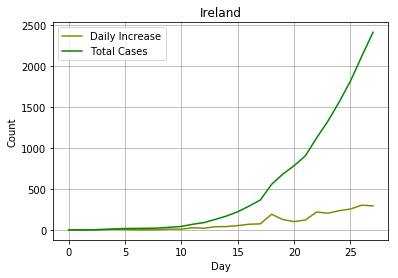

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df.DailyIncrease, color = '#888800FF', label = 'Daily Increase')
plt.plot(df.Total, color = '#008800FF', label = 'Total Cases')

plt.title(country)
plt.legend()
plt.grid()
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

We can fit these curves to the nearest matching exponential. 
First, define the exponential function, and then use scypy to fit the curve

In [6]:
# The function to fit datapoints to is exponential. B is the growth rate.
import numpy as np
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

# Use scypy
from scipy.optimize import curve_fit



Plot again, now with the smoothened version overlaid.

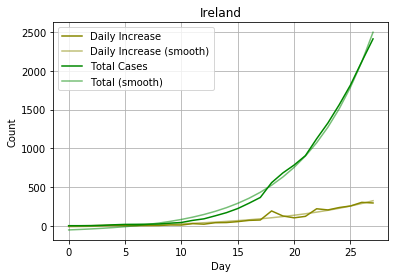

In [7]:

'''Plot the daily and total rates, and then the smootened version'''
params_daily, _ = curve_fit(exponential, df.index, df.DailyIncrease)
params_total, _ = curve_fit(exponential, df.index, df.Total)
# Plot the data
plt.plot(df.DailyIncrease, color = '#888800FF', label = 'Daily Increase')
plt.plot(exponential(df.index, *params_daily), 'r-', color = '#88880088', label = 'Daily Increase (smooth)')

plt.plot(df.Total, color = '#008800FF', label = 'Total Cases')
plt.plot(exponential(df.index, *params_total), 'r-',color = '#00880088', label = 'Total (smooth)')

plt.title(country)
plt.legend()
plt.grid()
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

## Parameters of interest
In the exponential function above, the 'b' parameter represented the growth rate. We can use the rule of seventy to estimate the doubling rate from this.

In [8]:
# A quick lambda to limit decimal places displayed
short = lambda x: '{:.1f}'.format(x)

# The true value of seventy in the rule of seventy
seventy = np.log(2)

# And a lambda for the rule of seventy
doubling_time = lambda x: seventy/x

daily_growth_rate = params_daily[1]
total_growth_rate = params_total[1]

daily_doubling_rate = doubling_time(daily_growth_rate)
total_doubling_rate = doubling_time(total_growth_rate)


print(f'Daily Detections: growth rate = {short(daily_growth_rate)}, doubling time = {short(daily_doubling_rate)} days')
print(f'Total Detections: growth rate = {short(total_growth_rate)}, doubling time = {short(total_doubling_rate)} days')

Daily Detections: growth rate = 0.1, doubling time = 6.5 days
Total Detections: growth rate = 0.2, doubling time = 4.3 days


## Rate of change in parameters of interest
We don't really have enough data points for this, but let's look to see if there is any emerging trend in parameters like the doubling rates.

Using the dataframe, for each row, recalculate the exponential curve, and from that, what the estimated doubling rate was on that day. That is, we show the history of estimates of doubling rates as they would have been calculated on that day.

In [9]:
def get_stats(df):
#     print('start')
    params_daily, _ = curve_fit(exponential, df.index, df.DailyIncrease)
    params_total, _ = curve_fit(exponential, df.index, df.Total)
#     print('fin')
    daily_growth_rate = params_daily[1]
    total_growth_rate = params_total[1]

    daily_doubling_rate = doubling_time(daily_growth_rate)
    total_doubling_rate = doubling_time(total_growth_rate)

    return daily_growth_rate, daily_doubling_rate, total_growth_rate, total_doubling_rate

In [10]:
minimum = 8

for index, row in df.iterrows():
    
    head = df.head(index)

    try:
        daily_growth_rate, daily_doubling_rate, total_growth_rate, total_doubling_rate = get_stats(head)
    except:
        daily, total = 0, 0
    
    df.at[index, 'DGR'] = daily_growth_rate
    df.at[index, 'DDR'] = daily_doubling_rate
    df.at[index, 'TGR'] = total_growth_rate
    df.at[index, 'TDR'] = total_doubling_rate
        
# print(df)

In the plot below, we want consistently negative growth rates, meaning that the number of new cases is declining daily.

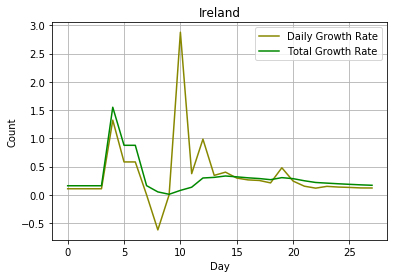

In [11]:
plt.plot(df.DGR, color = '#888800FF', label = 'Daily Growth Rate')
plt.plot(df.TGR, color = '#008800FF', label = 'Total Growth Rate')

plt.title(country)
plt.legend()
plt.grid()
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

## Death Rates
I don't want to be morbid, but these are starting to ramp up now too.

In [12]:
df = get_data('graph-deaths-daily')
print(df)

    DailyIncrease  Total
0               0      0
1               0      0
2               0      0
3               0      0
4               0      0
5               0      0
6               0      0
7               0      0
8               0      0
9               0      0
10              0      0
11              0      0
12              0      0
13              0      0
14              0      0
15              0      0
16              0      0
17              0      0
18              0      0
19              0      0
20              0      0
21              0      0
22              0      0
23              0      0
24              0      0
25              1      1
26              0      1
27              0      1
28              1      2
29              0      2
30              0      2
31              0      2
32              0      2
33              1      3
34              0      3
35              0      3
36              1      4
37              2      6
38              1      7


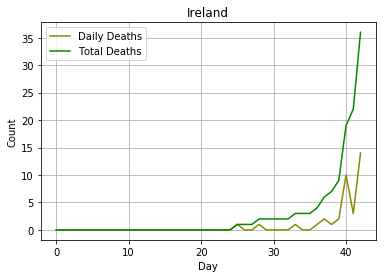

In [13]:

# Plot the data
plt.plot(df.DailyIncrease, color = '#888800FF', label = 'Daily Deaths')
plt.plot(df.Total, color = '#008800FF', label = 'Total Deaths')

plt.title(country)
plt.legend()
plt.grid()
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()